In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from tardis import *
from scipy import sparse,ndimage,interpolate
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
from multiprocessing import Pool
from functools import partial
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


In [2]:
rcParams['font.family']='STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'

In [15]:
flux_contrast_true = fromfile('clamato/map_128pix_deltaf.bin').reshape(128,128,128)
flux_true = (flux_contrast_true+1)/(flux_contrast_true+1).max()
tau_true = -log(flux_true).reshape(1,128,128,128)
tau_true = 0.3125*tau_true
flux_true = exp(-tau_true)

/home/zihaoli/miniconda3/envs/Tf_1/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [16]:
flux_true.mean()

0.8190118350074542

In [8]:
class load_universe:

    def __init__(self, tau,nc,bs):

        self.final_tau_RSD = tau
        self.nc = nc
        self.bs = bs
        
class load_lya():
    def __init__(self,flux_obs,skewers_fin,inverse_covar):
        self.vals_observed = flux_obs
        self.skewers_fin = skewers_fin
        self.inverse_covar = tf.SparseTensorValue(inverse_covar[0],inverse_covar[1],inverse_covar[2])

In [17]:
uni = load_universe(tau=tau_true.reshape(1,128,128,128),nc=128,bs=100)

<d_los>=2.500 Mpc/h


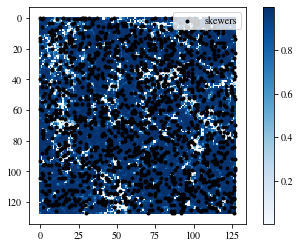

In [18]:
n_los = 1600
n = 128
mock_lya = lya_survey(uni,1.4,10,sm=1.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)
print('<d_los>=%.3f Mpc/h'%(100/n_los**0.5))

In [21]:
n_los = 1600
n = 128
for i in range(20):
    mock_lya = lya_survey(uni,1.4,10,sm=1.5,n_skewers=n_los)
    mock_lya.select_skewers()
    
    np.save("hydro100_20sim/flux_obs%s.npy"%i,mock_lya.vals_observed)
    np.save('hydro100_20sim/skewers_fin%s'%i,mock_lya.skewers_fin)
    np.save('hydro100_20sim/inverse_covar%s'%i,array(mock_lya.inverse_covar,dtype=object))
    np.save('hydro100_20sim/uni_final_tau_RSD%s'%i,uni.final_tau_RSD)

In [26]:
for i in range(20):
    skewers_fin = np.load('hydro100_20sim/skewers_fin%s.npy'%i)
    flux_obs = np.load('hydro100_20sim/flux_obs%s.npy'%i)
    inverse_covar = np.load('hydro100_20sim/inverse_covar%s.npy'%i,allow_pickle=True)
    uni_final_tau_RSD = np.load('hydro100_20sim/uni_final_tau_RSD%s.npy'%i)
    flux_contrast = flux_obs/flux_obs.mean()-1

    uni = load_universe(tau=uni_final_tau_RSD,nc=128,bs=100)
    mock_lya = load_lya(flux_obs,skewers_fin,inverse_covar)
    
    flux_obs = mock_lya.vals_observed
    flux_contrast = flux_obs/flux_obs.mean()-1

    p = np.vstack([0.78125*mock_lya.skewers_fin.T[0], 0.78125*mock_lya.skewers_fin.T[1],0.78125*mock_lya.skewers_fin.T[2], 
                   1/(mock_lya.inverse_covar[1])**0.5/mock_lya.vals_observed.mean(), flux_contrast]).T
    p.tofile("pixel_data%s.bin"%i)

In [584]:
# write config file
for i in range(20):
    cf = open("hydro100_20sim/run%i.cfg"%i, "w")
    cf.write("lx = %f\n" % 100)
    cf.write("ly = %f\n" % 100)
    cf.write("lz = %f\n" % 100)
    cf.write("num_pixels = %i\n" % 204800)
    cf.write("map_nx = %i\n" % 128)
    cf.write("map_ny = %i\n" % 128)
    cf.write("map_nz = %i\n" % 128)
    cf.write("corr_var_s = %f\n"%0.05)
    cf.write("corr_l_perp = %f\n" % 2.5)
    cf.write("corr_l_para = %f\n" % 2)
    cf.write("pcg_tol = 1.0e-3\n")
    cf.write("pcg_max_iter = 1000\n")
    cf.write('map_path = hydro128_20_%s.bin\n'%i)
    cf.write('pixel_data_path = pixel_data%s.bin'%i)

    cf.close()

In [ ]:
for i in range(2,20):
    skewers_fin = np.load('hydro100_20sim/skewers_fin%s.npy'%i)
    flux_obs = np.load('hydro100_20sim/flux_obs%s.npy'%i)
    inverse_covar = np.load('hydro100_20sim/inverse_covar%s.npy'%i,allow_pickle=True)
    uni_final_tau_RSD = np.load('hydro100_20sim/uni_final_tau_RSD%s.npy'%i)
    flux_contrast = flux_obs/flux_obs.mean()-1

    uni = load_universe(tau=uni_final_tau_RSD,nc=128,bs=100)
    mock_lya = load_lya(flux_obs,skewers_fin,inverse_covar)
    
    opt_recon = reconstruct_opt(uni,mock_lya,anneal_steps=array([2.5,2,1.5,1]),k=[6,36,3,0.6],c=0.4,maxiter=[50,50,50,1000])
    opt_recon.initmodel()
    tau_opt_recon,flux_los_opt_recon = opt_recon.run_model()
    flux_opt_recon = exp(-tau_opt_recon[0])
    save("hydro100_20sim/flux_opt_recon%s.npy"%i,flux_opt_recon)

In [45]:
flux_obs = []
flux_contrast_wiener = []
for i in range(20):
    flux_obs.append(load("hydro100_20sim/flux_obs%s.npy"%i))
    flux_contrast_wiener.append(fromfile('hydro100_20sim/hydro128_20_%s.bin'%i).reshape(128,128,128))

In [48]:
flux_wiener = [(flux_contrast_wiener[i]+1)*mean(flux_obs,axis=1)[i] for i in range(20)]

In [28]:
flux_orca = []
for i in range(20):
    flux_orca.append(load('hydro100_20sim/flux_opt_recon%s.npy'%i))

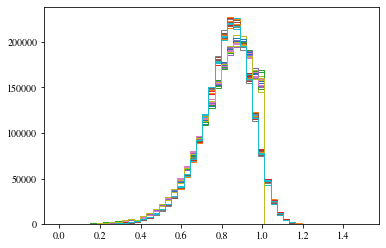

In [51]:
for i in range(20):
    hist(flux_orca[i].flatten(),histtype='step',bins=linspace(0,1.5,50))
    hist(flux_wiener[i].flatten(),histtype='step',bins=linspace(0,1.5,50))

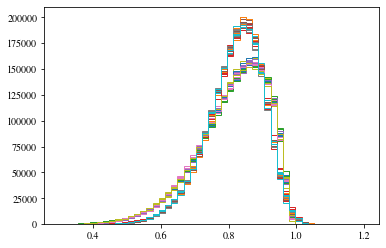

In [94]:
for i in range(20):
    hist(ndimage.gaussian_filter(flux_orca[i],2.56).flatten(),histtype='step',bins=linspace(0.3,1.2,50))
    hist(ndimage.gaussian_filter(flux_wiener[i],2.56).flatten(),histtype='step',bins=linspace(0.3,1.2,50))

In [172]:
b = []
for i in range(20):
    b.append(histogram(ndimage.gaussian_filter(flux_orca[i],2.56).flatten(),bins=linspace(0.3,1.2,100))[0])

In [311]:
def makehist(x,bins):
    data = []
    if len(shape(x))==4:
        for i in range(len(x)):
            data.append(histogram(ndimage.gaussian_filter(x[i],2.56).flatten(),bins=bins)[0])
    else:
        [a,b] = histogram(ndimage.gaussian_filter(x,2.56).flatten(),bins=bins)
        aa=insert(a,0,0)
        aa=append(aa,0)
        b = bins
        bb = append(b,b[-1])
        return [bb,aa]
    histdata = pd.DataFrame(data)
    a = array(histdata.mean())
    aa=insert(a,0,0)
    aa=append(aa,0)
    err = array(histdata.std())
    err = insert(err,0,0)
    err = append(err,0)
    b = bins
    bb = append(b,b[-1])
    
    return [bb,aa,err]

def plothist(a,ax=None,**kwargs):
    if ax:
        ax.plot(a[0],a[1],drawstyle='steps-pre',**kwargs)
        ax.fill_between(a[0],a[1]-a[2],a[1]+a[2],step='pre',alpha=0.5,color=kwargs['color'])
    else:
        plot(a[0],a[1],drawstyle='steps-pre',**kwargs)
        fill_between(a[0],a[1]-a[2],a[1]+a[2],step='pre',alpha=0.5,color=kwargs['color'])


In [207]:
a_orca = makehist(flux_orca,linspace(0.3,1.2,100))
a_wiener = makehist(flux_wiener,linspace(0.3,1.2,100))

In [233]:
flux_true_sm = ndimage.gaussian_filter(flux_true,2.56)

In [327]:
a_orca = makehist(flux_orca,linspace(0.3,1.1,100))
a_wiener = makehist(flux_wiener,linspace(0.3,1.1,100))

a_orca2 = makehist(flux_orca,linspace(0.9,1.1,30))
a_wiener2 = makehist(flux_wiener,linspace(0.9,1.1,30))



In [324]:
a_orca3 = makehist(flux_orca,linspace(0.2,0.6,30))
a_wiener3 = makehist(flux_wiener,linspace(0.2,0.6,30))

In [326]:
[x1,y1] = makehist(flux_true,linspace(0.3,1.1,100))

[x2,y2] = makehist(flux_true,linspace(0.9,1.1,30))



In [316]:
[x3,y3] = makehist(flux_true,linspace(0.2,0.6,40))

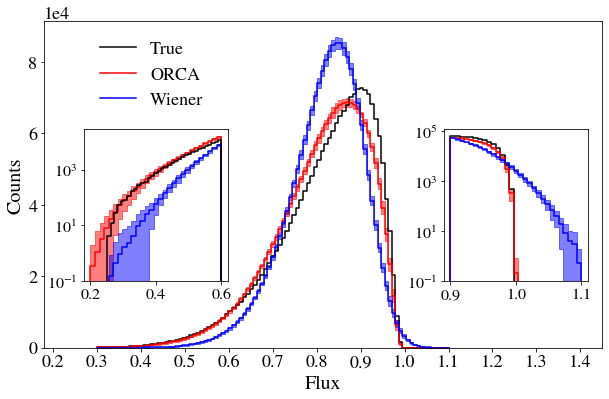

In [329]:
fig = figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
# h_list = {'histtype':'step','linewidth':2,'bins':linspace(0.3,1.1,100),'alpha':0.8,'density':False,'log':False}
# ax1.hist(flux_true_sm.flatten(),label='True',**h_list,color='k')
ax1.plot(x1,y1,label='True',drawstyle='steps-pre',color='k')
plothist(a_orca,ax1,color='r',label='ORCA')
plothist(a_wiener,ax1,color='b',label='Wiener')


legend(loc=2,fontsize=18,frameon=False,bbox_to_anchor=(0.07, 0.99))
ax1.set_xlabel('Flux',fontsize=20)

ax1.xaxis.set_major_locator(MultipleLocator(0.1))

ax1.set_ylabel('Counts',fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_xlim(0.18,1.45)
ax1.yaxis.get_major_formatter().set_powerlimits((0,1))
ax1.yaxis.offsetText.set_fontsize(18)
left, bottom, width, height = 0.68,0.28,0.2,0.35

ax2 = plt.axes([left,bottom,width,height])
ax2.plot(x2,y2,drawstyle='steps-pre',color='k')
ax2.set_yscale('log')

plothist(a_orca2,ax2,color='r',label='ORCA')
plothist(a_wiener2,ax2,color='b',label='Wiener')

ax3 = plt.axes([0.18,0.28,0.2,0.35])

plothist(a_orca3,ax3,color='r',label='ORCA')
plothist(a_wiener3,ax3,color='b',label='Wiener')
ax3.plot(x3,y3,drawstyle='steps-pre',color='k')
ax3.set_yscale('log')
ax2.set_ylim(1e-1,None)
ax3.set_ylim(1e-1,None)

ax2.tick_params(labelsize=16)
ax3.tick_params(labelsize=16)
ax1.set_ylim(0,None)
savefig('flux_pdf_mean.pdf',bbox_inches='tight')
# show()

In [116]:
import pandas as pd

In [173]:
histdata = pd.DataFrame(b)

In [174]:
a = array(histdata.mean())
b = linspace(0.3,1.2,100)

In [155]:
err = array(histdata.std())

In [63]:
flux_true = flux_true[0]

In [59]:
a = []
b = []
for i in range(20):
    a_temp,b_temp = eigen_stuff(flux_true,
                  [
                   flux_orca[i],
                   flux_wiener[i],
                   ],
                   kernel_sizes=[2]*4,pad = 1, rebin_size=100)
    a.append(a_temp)
    b.append(b_temp)

0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)
0 (128, 128, 128)
1 (128, 128, 128)


In [60]:
def classify(e,lam=0.052):
    return sum(e>lam,axis=3).flatten()

def choose_lam(e,frac_lim):
    a = -1
    b = 1
    lam = (a+b)/2
    label = classify(e,lam)
    while True:
        frac = len(label[label==3])/len(label)
        if frac-frac_lim>0:
            a = lam
            lam = (a+b)/2
        else:
            b = lam
            lam = (a+b)/2
        label = classify(e,lam)
        if abs(frac-frac_lim)<0.001:
            break
    
    return lam
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

In [64]:
pad=1
sigma=2*1.28
flux_true_sm = ndimage.gaussian_filter(flux_true[pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
e_dm = compute_deformation_tensor(flux_true_sm)
true_label = classify(e_dm[0],choose_lam(e_dm[0],0.22))
len(true_label[true_label==3])/len(true_label)

/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0.22351747871400177

In [66]:
wiener_label = []
for i in range(20):
    flux_wiener_sm = ndimage.gaussian_filter(flux_wiener[i][pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
    e_dm = compute_deformation_tensor(flux_wiener_sm)
    wiener_label.append(classify(e_dm[0],choose_lam(e_dm[0],0.22)))
    print(i,end=' ')

/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:19: RuntimeWarning: invalid value encountered in true_divide
  t_kxkx = kx_3d*kx_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:20: RuntimeWarning: invalid value encountered in true_divide
  t_kxky = kx_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:21: RuntimeWarning: invalid value encountered in true_divide
  t_kxkz = kx_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:22: RuntimeWarning: invalid value encountered in true_divide
  t_kyky = ky_3d*ky_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:23: RuntimeWarning: invalid value encountered in true_divide
  t_kykz = ky_3d*kz_3d*delta_k/ksq_3d
/data/home/zihaoli/tardis-tf-master/tardis/tardis/analysis.py:24: RuntimeWarning: invalid value encountered in true_divide
  t_kzkz = kz_3d*kz_3d*delta_k/ksq_3d


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

In [ ]:
orca_label = []
for i in range(20):
    flux_opt_sm = ndimage.gaussian_filter(flux_orca[i][pad:-1*pad,pad:-1*pad,pad:-1*pad],sigma,mode='wrap')
    e_dm = compute_deformation_tensor(flux_opt_sm)
    orca_label.append(classify(e_dm[0],choose_lam(e_dm[0],0.22)))
    print(i)

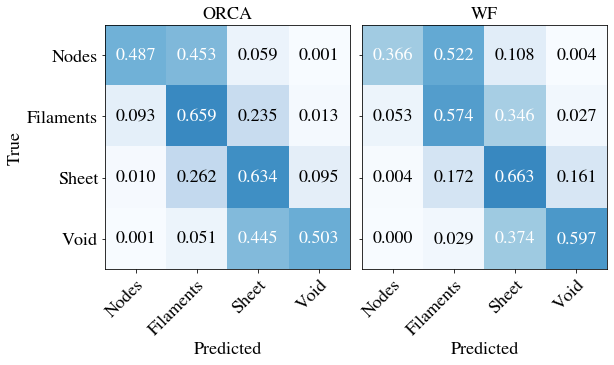

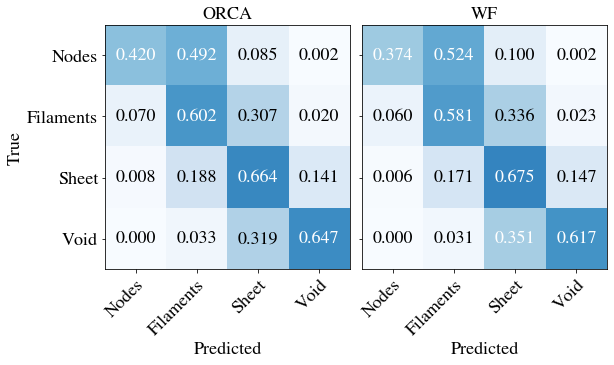

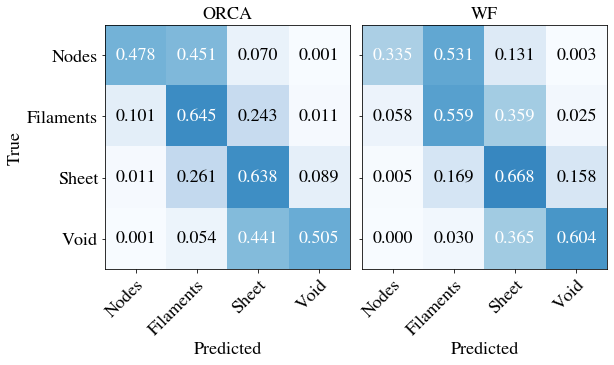

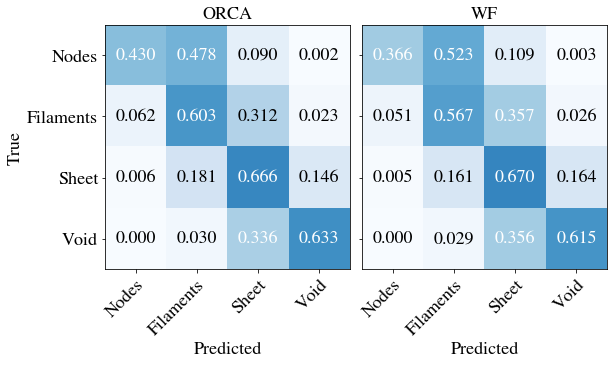

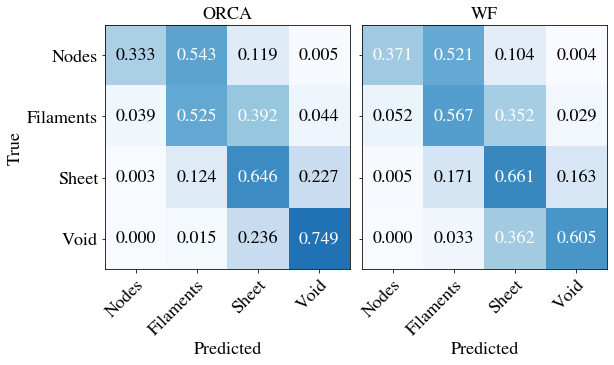

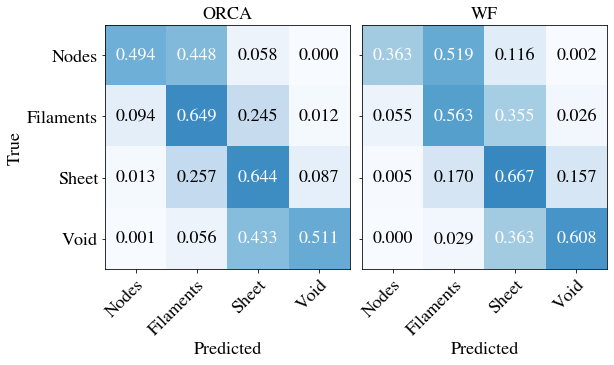

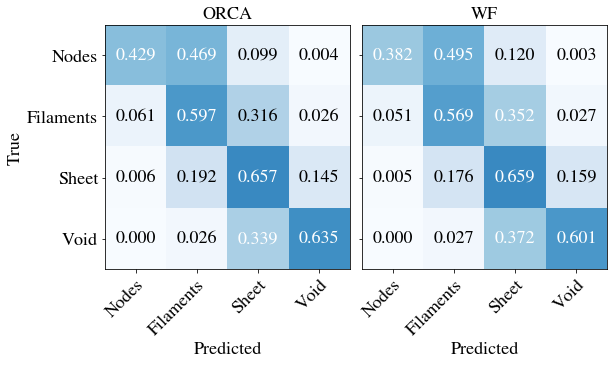

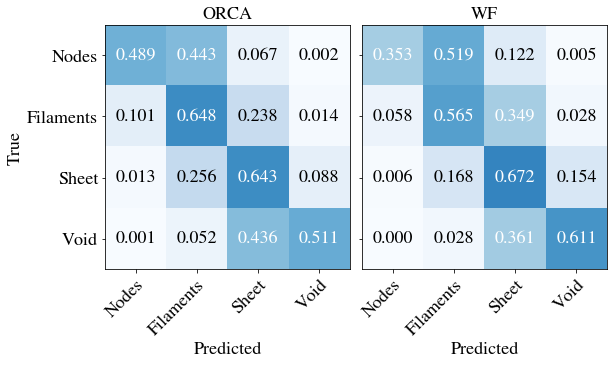

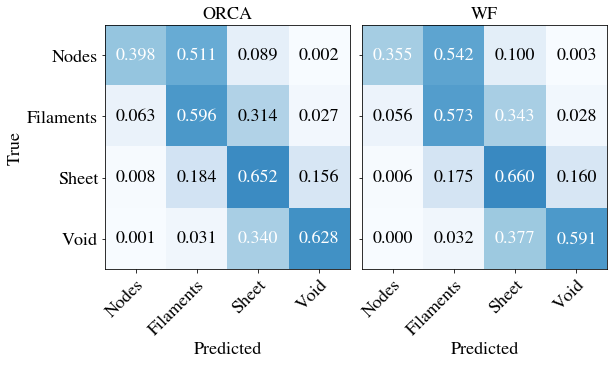

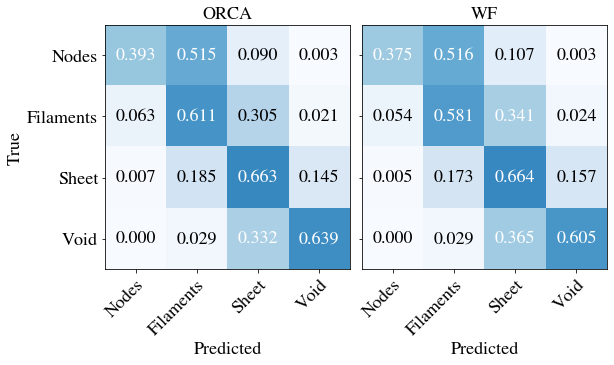

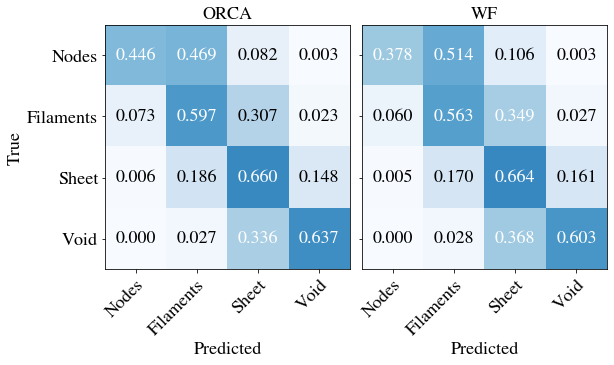

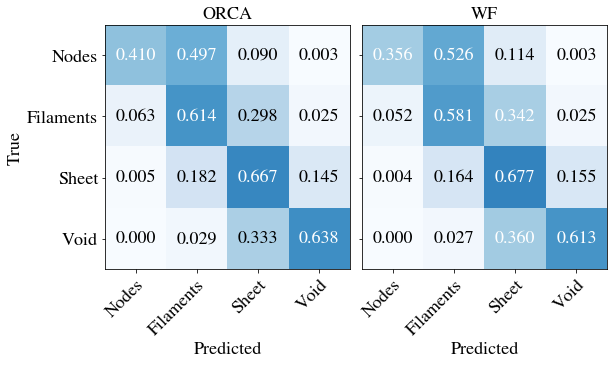

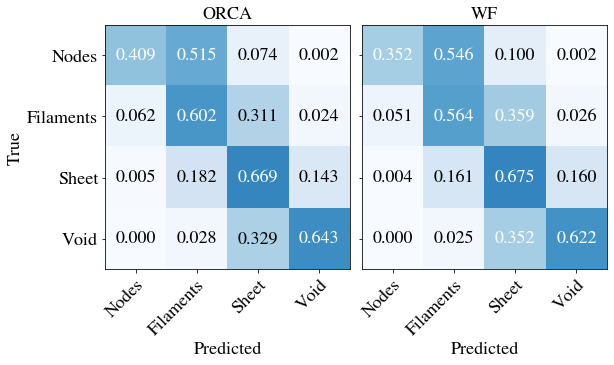

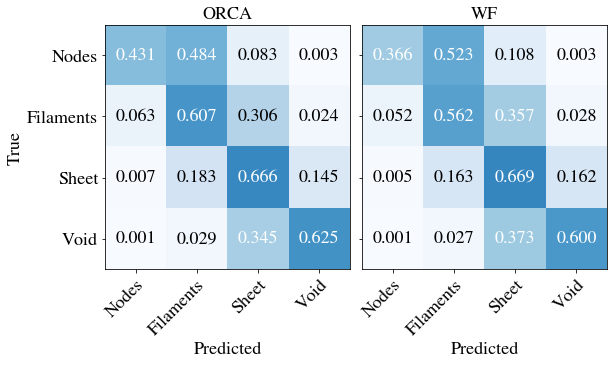

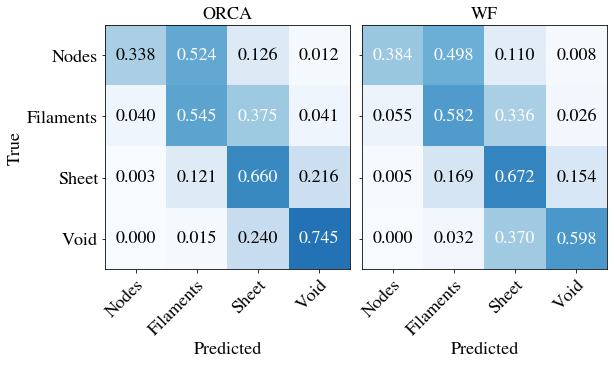

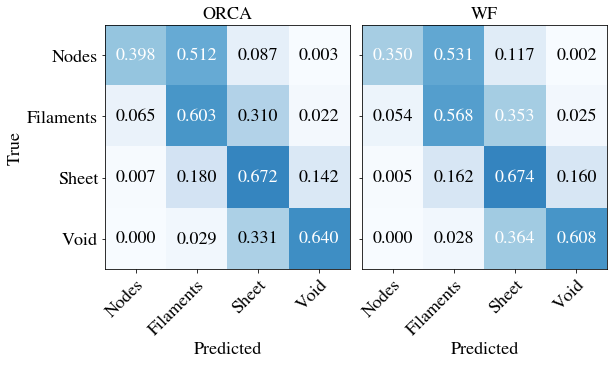

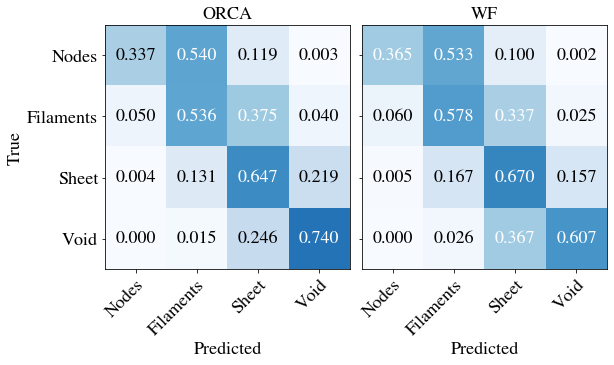

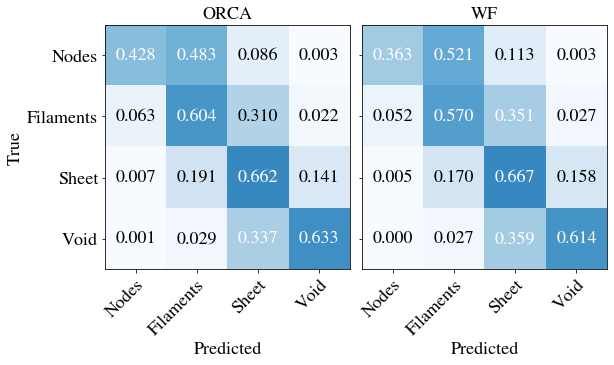

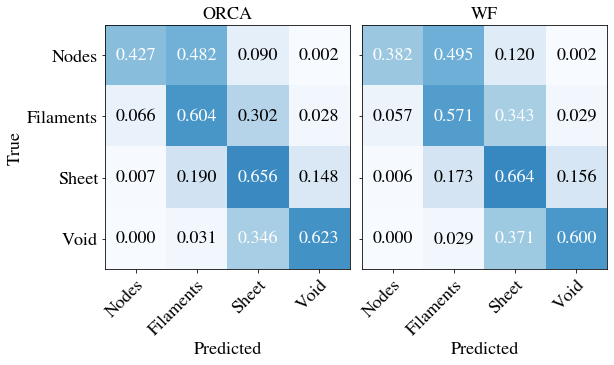

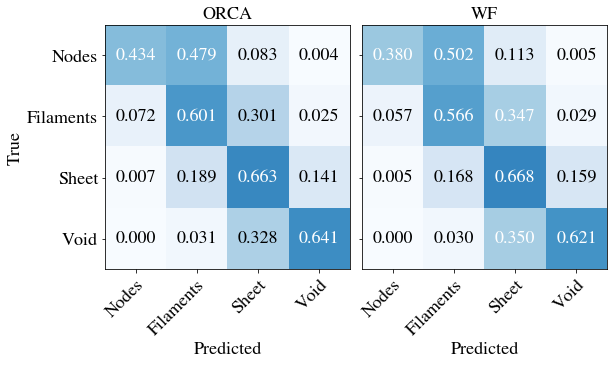

In [92]:
y_true = true_label
titles = ['ORCA','WF']
classes=np.array(["Nodes","Filaments","Sheet","Void"])
for j in range(20):
    fig, axes = plt.subplots(1,2,sharey='row',figsize=(9,4.5))    
    subplots_adjust(wspace=0.05)
    y = [orca_label[j],wiener_label[j]]
    for i,ax in enumerate(axes):

        y_pred = y[i]
        cm = confusion_matrix(y_true, y_pred)
        classes = classes[unique_labels(y_true, y_pred)]
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, interpolation='nearest', cmap='Blues',vmin=0,vmax=1)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
              )

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
        plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontsize=18)
        ax.set_xlabel('Predicted',fontsize=18)
        ax.set_title(titles[i],fontsize=18)
        normalize = True
        fmt = '.3f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",fontsize=18)
    axes[0].set_ylabel('True',fontsize=18)
    show()
# fig.tight_layout()
# savefig('confusion_matrix.pdf',bbox_inches = 'tight',transparent=True)

## The average accuracy

In [75]:
cm_orca = []
cm_wiener = []
for i in range(20):
    cm_temp = confusion_matrix(true_label, orca_label[i])
    cm_temp = cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    cm_orca.append(cm_temp)
    
    cm_temp = confusion_matrix(true_label, wiener_label[i])
    cm_temp = cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    cm_wiener.append(cm_temp)

In [87]:
cm1 = mean(cm_orca,axis=0)
cm2 = mean(cm_wiener,axis=0)

In [88]:
cm_all = [cm1,cm2]

Text(0, 0.5, 'True')

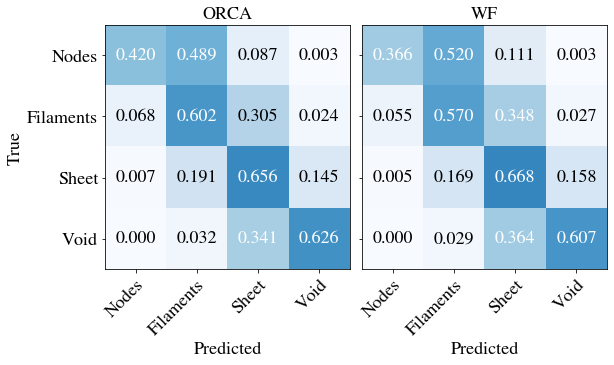

In [89]:
fig, axes = plt.subplots(1,2,sharey='row',figsize=(9,4.5))    
subplots_adjust(wspace=0.05)
y_true = true_label
titles = ['ORCA','WF']
y = [orca_label[1],wiener_label[1]]
classes=np.array(["Nodes","Filaments","Sheet","Void"])



for i,ax in enumerate(axes):

    y_pred = y[i]
    
    classes = classes[unique_labels(y_true, y_pred)]
    cm = cm_all[i]
    
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues',vmin=0,vmax=1)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
          )
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_xticklabels() + ax.get_yticklabels(),fontsize=18)
    ax.set_xlabel('Predicted',fontsize=18)
    ax.set_title(titles[i],fontsize=18)
    normalize = True
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",fontsize=18)
axes[0].set_ylabel('True',fontsize=18)
# fig.tight_layout()
# savefig('confusion_matrix.pdf',bbox_inches = 'tight',transparent=True)